# Train a model to recognize handwritten digits from the MNIST data set use gradient descent to train the model

In [3]:
# Import the libraries we need for this lab
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import polars as pd

# Load the data set

In [4]:
# Download the data and apply some transformations
dataset = datasets.MNIST('data/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('data/', train=False, download=True, transform=transforms.ToTensor())
# Split the data into training and validation data sets
train_ds, val_ds = random_split(dataset, [50000, 10000])
# Create data loaders to load the data in batches
train_loader = DataLoader(train_ds, batch_size=32)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

100%|██████████| 9912422/9912422 [00:00<00:00, 44130561.86it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 10699142.72it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21967066.02it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 2257706.66it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



# Define the model

In [5]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    return model

# Train the model

In [6]:
model = get_model()
# Define the loss function
loss_fn = F.cross_entropy
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
# Define the training loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.view(X.shape[0], -1))
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Evaluate the model

In [7]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.view(X.shape[0], -1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train the model for 10 epochs

In [8]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(val_loader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310808  [    0/50000]
loss: 2.268224  [ 3200/50000]
loss: 2.201190  [ 6400/50000]
loss: 2.122779  [ 9600/50000]
loss: 2.024237  [12800/50000]
loss: 1.730485  [16000/50000]
loss: 1.583422  [19200/50000]
loss: 1.160181  [22400/50000]
loss: 1.000717  [25600/50000]
loss: 0.984336  [28800/50000]
loss: 0.981970  [32000/50000]
loss: 0.674168  [35200/50000]
loss: 0.576816  [38400/50000]
loss: 0.371876  [41600/50000]
loss: 0.587938  [44800/50000]
loss: 0.513431  [48000/50000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.016067 

Epoch 2
-------------------------------
loss: 0.488114  [    0/50000]
loss: 0.598683  [ 3200/50000]
loss: 0.346651  [ 6400/50000]
loss: 0.331094  [ 9600/50000]
loss: 0.309018  [12800/50000]
loss: 0.278146  [16000/50000]
loss: 0.318954  [19200/50000]
loss: 0.360758  [22400/50000]
loss: 0.378022  [25600/50000]
loss: 0.648991  [28800/50000]
loss: 0.554439  [32000/50000]
loss: 0.379883  [35200/50000]
loss: 0.260685  [38400/50000

# Save the model

In [9]:
torch.save(model.state_dict(), "mnist_model.pth")
print("Saved PyTorch Model State to mnist_model.pth")

Saved PyTorch Model State to mnist_model.pth


# Load the model

In [10]:
model = get_model()
model.load_state_dict(torch.load("mnist_model.pth"))

<All keys matched successfully>

# Evaluate the model on the test data set

In [11]:
test(test_loader, model)

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.005511 



# Make predictions on a single image from the test data set

Shape: torch.Size([1, 28, 28])


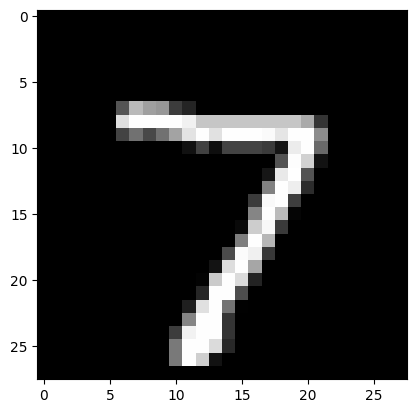

In [12]:
# Pick a random test example
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)

# Add a batch dimension

In [13]:
img.unsqueeze_(0)
print('Shape:', img.shape)

Shape: torch.Size([1, 1, 28, 28])


# Predict the digit using our model

In [14]:
pred = model(img.view(img.shape[0], -1))
print('Predicted:', pred.argmax(1).item())

Predicted: 7


# Make predictions on a batch of images

In [23]:
preds = model(img.view(img.shape[0], -1))

In [24]:
for img, label in test_loader:
    print(img.shape)
    preds = model(img)
    break
print("Predicted:", preds.argmax(1))
print("Actual:", label)


torch.Size([32, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (896x28 and 784x64)

# visualize the weights and biases

In [30]:
# Get the weights and biases
weights = model[0].weight.data
biases = model[0].bias.data
print(weights.shape, biases.shape)

torch.Size([64, 784]) torch.Size([64])


# Reshape the weights into 28x28 images

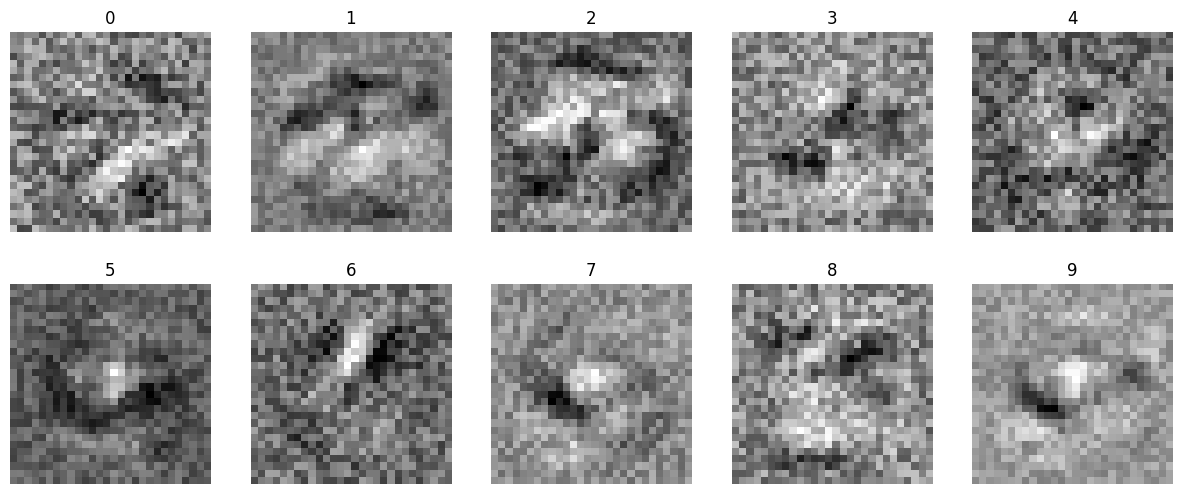

In [31]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(weights[i].view(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(str(i))
plt.show()


# Visualize the activations

In [34]:
outputs = (32, 10)

In [35]:
# Get the activations using our model
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break
print('Outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([32, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (896x28 and 784x64)

# save and close the notebook

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'MNIST.ipynb'])
os.system('jupyter nbconvert --to tml MNIST.ipynb')
os.system('jupyter nbconvert --to html MNIST.ipynb')

1